In [1]:
#Credits to HyungsukKang's kernel on stratified K fold on XGBoost
#https://www.kaggle.com/sudosudoohio/stratified-kfold-xgboost-eda-tutorial-0-281


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Download the dataset from this link and if you face error in code for importing the data files, make necessary changes to the path to make sure code can locate the dataset.
# https://www.kaggle.com/yelp-dataset/yelp-dataset/downloads/yelp-dataset.zip/7

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
yelp_business = pd.read_csv('D:\Yelp Data\yelp csv\yelp_business.csv')

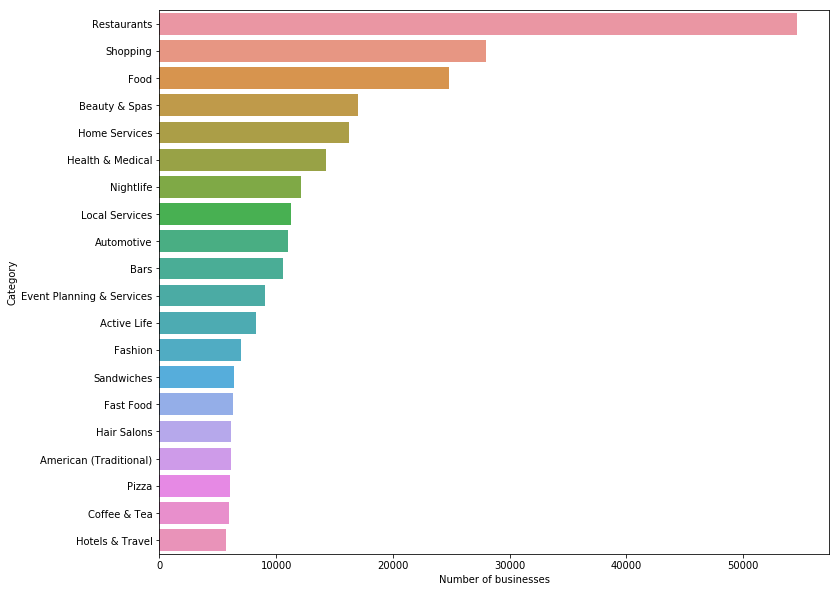

In [4]:
business_cats=';'.join(yelp_business['categories'])
cats=pd.DataFrame(business_cats.split(';'),columns=['category'])
cats_ser = cats.category.value_counts()


cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

plt.figure(figsize=(12,10))
f = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
f.set_ylabel('Category')
f.set_xlabel('Number of businesses');

In [6]:
cats_np = np.array(cats_df)

yb = np.array(yelp_business)
yb.shape

l = []
for i in range(0,20):
    l.append(cats_np[i][0])
    print(cats_np[i][0])

Restaurants
Shopping
Food
Beauty & Spas
Home Services
Health & Medical
Nightlife
Local Services
Automotive
Bars
Event Planning & Services
Active Life
Fashion
Sandwiches
Fast Food
Hair Salons
American (Traditional)
Pizza
Coffee & Tea
Hotels & Travel


In [8]:
#for cat in range(12,23):
cat = 12
for j in l:
    cat = cat + 1
    yb = np.insert(yb, cat, 0, axis=1)  
    print(j,cat)
    for i in range(0,yelp_business.shape[0]):
        if np.char.find(yb[i,12],j) != -1:
            yb[i,cat] = 1

Restaurants 13
Shopping 14
Food 15
Beauty & Spas 16
Home Services 17
Health & Medical 18
Nightlife 19
Local Services 20
Automotive 21
Bars 22
Event Planning & Services 23
Active Life 24
Fashion 25
Sandwiches 26
Fast Food 27
Hair Salons 28
American (Traditional) 29
Pizza 30
Coffee & Tea 31
Hotels & Travel 32


In [9]:
l

['Restaurants',
 'Shopping',
 'Food',
 'Beauty & Spas',
 'Home Services',
 'Health & Medical',
 'Nightlife',
 'Local Services',
 'Automotive',
 'Bars',
 'Event Planning & Services',
 'Active Life',
 'Fashion',
 'Sandwiches',
 'Fast Food',
 'Hair Salons',
 'American (Traditional)',
 'Pizza',
 'Coffee & Tea',
 'Hotels & Travel']

In [10]:
for i in l:
    yelp_business[i] = 0

In [12]:
yelp_business[['Restaurants', 'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel'
]] = yb[:,13:33]

# FINISH IMPORTING FEATURES

In [13]:
review = pd.read_csv('D:\Yelp Data\yelp csv\yelp_review.csv')

review_busines = review.groupby(by='business_id')

review_businesid = pd.DataFrame()
review_businesid['Mean'] = review_busines['stars'].mean().round(decimals = 3)*1000
review_businesid['Median'] = review_busines['stars'].median()
review_businesid['NumberOfReviews'] = review_busines['stars'].count()
review_businesid['STDOfReviews'] = review_busines['stars'].std().round(decimals = 3)*1000
#review_businesid['SKEW'] = review_busines['stars'].skew()

checkin = pd.read_csv("D:\Yelp Data\yelp csv\yelp_checkin.csv")

checkin_bus = checkin.groupby(by='business_id')

checkin_busid = pd.DataFrame()
checkin_busid['TotalCheckins'] = checkin_bus['checkins'].sum()

checkin_busid.reset_index(inplace=True)
review_businesid.reset_index(inplace=True)


review_businesid = pd.merge(left=review_businesid,right=checkin_busid,on='business_id', how='left')

yelp_business = pd.merge(left=yelp_business,right=review_businesid,on='business_id',how='left')

# CLEAR UNWANTED DATA

In [14]:
# Clear vars some vars to free up memory

cats_np = 0
yb = 0
review = 0
review_businesid = 0
checkin = 0
checkin_bus = 0

# VIZ LOCATION DATA

1    146702
0     27865
Name: is_open, dtype: int64


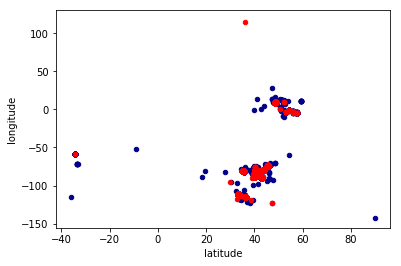

In [18]:
ax1 = yelp_business[yelp_business['is_open'] ==1].plot(kind='scatter',x = 'latitude', y = 'longitude', c='DarkBlue')
ax2 = yelp_business[yelp_business['is_open'] ==0].plot(kind='scatter',x = 'latitude', y = 'longitude', c='red', ax=ax1)
print(yelp_business['is_open'].value_counts())

1    139978
0     26697
Name: is_open, dtype: int64


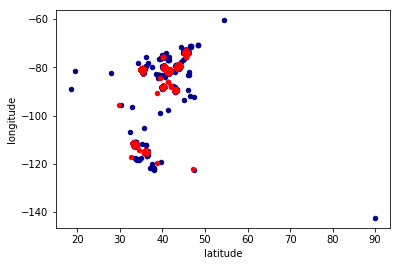

In [19]:
ax1 = yelp_business[(yelp_business['is_open'] ==1) & (yelp_business['latitude'] > 15) & (yelp_business['longitude'] < -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='DarkBlue')    
ax2 = yelp_business[(yelp_business['is_open'] ==0) & (yelp_business['latitude'] > 15) & (yelp_business['longitude'] < -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='red', ax=ax1) 

print(yelp_business['is_open'][(yelp_business['latitude'] > 15) & (yelp_business['longitude'] < -50)].value_counts())

1    37
0     1
Name: is_open, dtype: int64


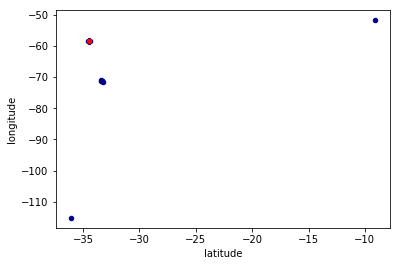

In [20]:
ax1 = yelp_business[(yelp_business['is_open'] ==1) & (yelp_business['latitude'] < 15) & (yelp_business['longitude'] < -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='DarkBlue')    
ax2 = yelp_business[(yelp_business['is_open'] ==0) & (yelp_business['latitude'] < 15) & (yelp_business['longitude'] < -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='red', ax=ax1)

print(yelp_business['is_open'][(yelp_business['latitude'] < 15) & (yelp_business['longitude'] < -50)].value_counts())

1    6687
0    1166
Name: is_open, dtype: int64


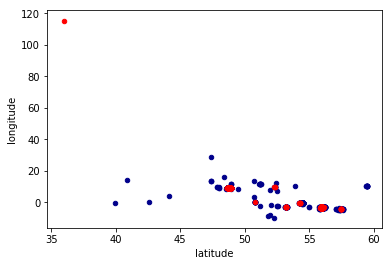

In [21]:
ax1 = yelp_business[(yelp_business['is_open'] ==1) & (yelp_business['latitude'] > 15) & (yelp_business['longitude'] > -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='DarkBlue')    
ax2 = yelp_business[(yelp_business['is_open'] ==0) & (yelp_business['latitude'] > 15) & (yelp_business['longitude'] > -50)].plot(kind='scatter', x = 'latitude', y = 'longitude', c='red', ax=ax1) 

print(yelp_business['is_open'][(yelp_business['latitude'] > 15) & (yelp_business['longitude'] > -50)].value_counts())

In [24]:
b_type =  ['Restaurants', 'Shopping', 'Food','Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife','Local Services', 'Automotive', 'Bars']

# LogisticRegression

In [25]:
# FEATURE COLUMNS
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

NF_sm_acc_type = {} 
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res)
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)
    L = [0.000001, 0.00001, 0.0001,0.001,0.01,0.1,1,10,15,20,25]
    accuracy = {}
    for i in L:
        LR = LogisticRegression(C=i)
        LR.fit(X_res,y_res)
        pred_y = LR.predict(test_X)

        accuracy[i] = 100*accuracy_score(test_y,pred_y)
    NF_sm_acc_type[t] = [t, accuracy,confusion_matrix(test_y,pred_y)]
    
    
    

In [26]:
NF_sm_acc_type

{'Restaurants': ['Restaurants',
  {1e-06: 56.68253387037715,
   1e-05: 57.427071890638345,
   0.0001: 58.62931771024045,
   0.001: 60.89954839497131,
   0.01: 61.503722690101306,
   0.1: 61.74783351641645,
   1: 61.67460026852191,
   10: 61.7905529110216,
   15: 61.66239472720615,
   20: 61.74783351641645,
   25: 61.79665568167948},
  array([[3091, 1109],
         [5151, 7035]], dtype=int64)],
 'Shopping': ['Shopping',
  {1e-06: 51.41801715919924,
   1e-05: 49.65443279313632,
   0.0001: 49.82125834127741,
   0.001: 53.348427073403236,
   0.01: 54.122974261201136,
   0.1: 54.50428979980935,
   1: 54.516205910390845,
   10: 54.6234509056244,
   15: 54.551954242135366,
   20: 54.516205910390845,
   25: 54.46854146806482},
  array([[ 836,  352],
         [3469, 3735]], dtype=int64)],
 'Food': ['Food',
  {1e-06: 56.23665100384451,
   1e-05: 55.841520717642034,
   0.0001: 57.165741136266554,
   0.001: 58.009397693293465,
   0.01: 57.39000427167878,
   0.1: 56.29004698846647,
   1: 55.9910294

# RUN DIFFERENT SAMPLING METHODS

In [44]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import CondensedNearestNeighbour, EditedNearestNeighbours,RepeatedEditedNearestNeighbours, AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule, OneSidedSelection, RandomUnderSampler, TomekLinks


In [45]:
def sampling(train_X, train_y, sampleType):
    
    print(sampleType + '\n')
    
    if (sampleType == "SMOTEENN"):
        return SMOTEENN(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "SMOTETomek"):
        return SMOTETomek(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "ADASYN"):
        return ADASYN(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "RandomOverSampler"):
        return RandomOverSampler(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "SMOTE"):
        return SMOTE(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "CondensedNearestNeighbour"):
        return CondensedNearestNeighbour(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "EditedNearestNeighbours"):
        return EditedNearestNeighbours(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "RepeatedEditedNearestNeighbours"):
        return RepeatedEditedNearestNeighbours(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "AllKNN"):
        return AllKNN(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "InstanceHardnessThreshold"):
        return InstanceHardnessThreshold(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "NearMiss"):
        return NearMiss(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "NeighbourhoodCleaningRule"):
        return NeighbourhoodCleaningRule(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "OneSidedSelection"):
        return OneSidedSelection(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "RandomUnderSampler"):
        return RandomUnderSampler(random_state = 42).fit_sample(train_X, train_y)
    elif (sampleType == "TomekLinks"):
        return TomekLinks(random_state = 42).fit_sample(train_X, train_y)

In [46]:
# FEATURE COLUMNS
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

NF_sm_acc_type = [[] for i in range(len(b_type))]
samplingList = ["Nothing","SMOTEENN", "SMOTETomek", "ADASYN", "RandomOverSampler", "SMOTE", "EditedNearestNeighbours", "RepeatedEditedNearestNeighbours", "AllKNN", "NearMiss", "NeighbourhoodCleaningRule", "OneSidedSelection", "RandomUnderSampler", "TomekLinks"]  
k = 0    
    
for t in b_type:
    
    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    NF_sm_acc_type.append([])  

        
    for x in range (0, len(samplingList)):
        if (samplingList[x] == "SMOTEENN"):
            X_res, y_res = SMOTEENN(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "SMOTETomek"):
            X_res, y_res = SMOTETomek(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "ADASYN"):
            X_res, y_res = ADASYN(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "RandomOverSampler"):
            X_res, y_res = RandomOverSampler(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "SMOTE"):
            X_res, y_res = SMOTE(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "CondensedNearestNeighbour"):
            X_res, y_res = CondensedNearestNeighbour(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "EditedNearestNeighbours"):
            X_res, y_res = EditedNearestNeighbours(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "RepeatedEditedNearestNeighbours"):
            X_res, y_res = RepeatedEditedNearestNeighbours(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "AllKNN"):
            X_res, y_res = AllKNN(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "InstanceHardnessThreshold"):
            X_res, y_res = InstanceHardnessThreshold(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "NearMiss"):
            X_res, y_res = NearMiss(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "NeighbourhoodCleaningRule"):
            X_res, y_res = NeighbourhoodCleaningRule(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "OneSidedSelection"):
            X_res, y_res = OneSidedSelection(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "RandomUnderSampler"):
            X_res, y_res = RandomUnderSampler(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "TomekLinks"):
            X_res, y_res = TomekLinks(random_state = 42).fit_sample(train_X, train_y)
        elif (samplingList[x] == "Nothing"):
            X_res = train_X
            y_res = train_y
        
        X_res = pd.DataFrame(X_res)
        y_res = pd.DataFrame(y_res)
        test_X = pd.DataFrame(test_X)
        test_y = pd.DataFrame(test_y)
    
        L = [0.000001, 0.00001, 0.0001,0.001,0.01,0.1,1,10,15,20,25]
        accuracy = {}
    
        for i in L:
            LR = LogisticRegression(C=i)
            LR.fit(X_res,y_res)
            pred_y = LR.predict(test_X)
            accuracy[i] = 100*accuracy_score(test_y,pred_y)
        
        print(str(t) + ': ' + samplingList[x] + ' Accuracy:\n' + str(accuracy) + '\n')
    
        LR = LogisticRegression(C=0.001)
        LR.fit(X_res,y_res)
        pred_y = LR.predict(test_X)
    
        print(str(t) + ': ' + samplingList[x] + ' Confusion Matrix:\n' + str(confusion_matrix(test_y,pred_y)) + '\n')
        print(str(t) + ': ' + samplingList[x] + ' Accuracy Score:\n' + str(accuracy_score(test_y,pred_y)) + '\n')
        NF_sm_acc_type[k].append((t, x, accuracy, confusion_matrix(test_y,pred_y)))
        

    k = k + 1
    
    

Restaurants: Nothing Accuracy:
{1e-06: 74.07543024533138, 1e-05: 74.14866349322592, 0.0001: 74.23410228243623, 0.001: 74.56365189796166, 0.01: 75.14951788111803, 0.1: 75.32039545953863, 1: 75.31429268888076, 10: 75.39973147809106, 15: 75.35090931282802, 20: 75.32649823019652, 25: 75.4180397900647}

Restaurants: Nothing Confusion Matrix:
[[  114  4086]
 [   82 12104]]

Restaurants: Nothing Accuracy Score:
0.7456365189796167

Restaurants: SMOTEENN Accuracy:
{1e-06: 46.002685219089464, 1e-05: 46.814353716587334, 0.0001: 47.22934212132308, 0.001: 51.129012571707555, 0.01: 55.272793848407176, 0.1: 56.011229098010496, 1: 55.73050164774808, 10: 56.7252532649823, 15: 55.6938850238008, 20: 56.536067374588065, 25: 56.06005126327352}

Restaurants: SMOTEENN Confusion Matrix:
[[3486  714]
 [7294 4892]]

Restaurants: SMOTEENN Accuracy Score:
0.5112901257170755

Restaurants: SMOTETomek Accuracy:
{1e-06: 56.31636763090443, 1e-05: 57.256194312217744, 0.0001: 58.324179177346515, 0.001: 61.04601489076040

Shopping: RandomOverSampler Confusion Matrix:
[[ 870  318]
 [3666 3538]]

Shopping: RandomOverSampler Accuracy Score:
0.5252621544327931

Shopping: SMOTE Accuracy:
{1e-06: 51.41801715919924, 1e-05: 49.65443279313632, 0.0001: 49.82125834127741, 0.001: 53.348427073403236, 0.01: 54.122974261201136, 0.1: 54.50428979980935, 1: 54.516205910390845, 10: 54.6234509056244, 15: 54.551954242135366, 20: 54.516205910390845, 25: 54.46854146806482}

Shopping: SMOTE Confusion Matrix:
[[ 863  325]
 [3590 3614]]

Shopping: SMOTE Accuracy Score:
0.5334842707340324

Shopping: EditedNearestNeighbours Accuracy:
{1e-06: 85.84366062917064, 1e-05: 85.84366062917064, 0.0001: 85.84366062917064, 0.001: 85.83174451858913, 0.01: 85.83174451858913, 0.1: 85.83174451858913, 1: 85.84366062917064, 10: 85.84366062917064, 15: 85.84366062917064, 20: 85.84366062917064, 25: 85.84366062917064}

Shopping: EditedNearestNeighbours Confusion Matrix:
[[   0 1188]
 [   1 7203]]

Shopping: EditedNearestNeighbours Accuracy Score:
0.85

Food: NeighbourhoodCleaningRule Accuracy:
{1e-06: 82.5822298163178, 1e-05: 82.53951302862025, 0.0001: 82.53951302862025, 0.001: 82.53951302862025, 0.01: 82.49679624092269, 0.1: 82.44340025630072, 1: 82.45407945322512, 10: 82.4647586501495, 15: 82.45407945322512, 20: 82.45407945322512, 25: 82.45407945322512}

Food: NeighbourhoodCleaningRule Confusion Matrix:
[[   0 1631]
 [   4 7729]]

Food: NeighbourhoodCleaningRule Accuracy Score:
0.8253951302862025

Food: OneSidedSelection Accuracy:
{1e-06: 82.5822298163178, 1e-05: 82.53951302862025, 0.0001: 82.53951302862025, 0.001: 82.53951302862025, 0.01: 82.51815463477146, 0.1: 82.51815463477146, 1: 82.51815463477146, 10: 82.51815463477146, 15: 82.51815463477146, 20: 82.51815463477146, 25: 82.51815463477146}

Food: OneSidedSelection Confusion Matrix:
[[   0 1631]
 [   4 7729]]

Food: OneSidedSelection Accuracy Score:
0.8253951302862025

Food: RandomUnderSampler Accuracy:
{1e-06: 57.24049551473729, 1e-05: 57.00555318240068, 0.0001: 56.781290046988

Home Services: SMOTEENN Accuracy:
{1e-06: 52.55039078568491, 1e-05: 54.31921020156314, 0.0001: 54.380913204442614, 0.001: 53.475935828877006, 0.01: 53.70218017276841, 0.1: 53.7227478403949, 1: 53.78445084327437, 10: 53.78445084327437, 15: 53.7433155080214, 20: 53.763883175647884, 25: 53.7227478403949}

Home Services: SMOTEENN Confusion Matrix:
[[ 142   82]
 [2180 2458]]

Home Services: SMOTEENN Accuracy Score:
0.5347593582887701

Home Services: SMOTETomek Accuracy:
{1e-06: 58.206499382969966, 1e-05: 58.59728506787331, 0.0001: 58.53558206499383, 0.001: 59.11147675853559, 0.01: 59.00863842040312, 0.1: 59.04977375565611, 1: 59.00863842040312, 10: 59.193747429041544, 15: 58.16536404771699, 20: 58.74125874125874, 25: 58.16536404771699}

Home Services: SMOTETomek Confusion Matrix:
[[ 135   89]
 [1899 2739]]

Home Services: SMOTETomek Accuracy Score:
0.5911147675853559

Home Services: ADASYN Accuracy:
{1e-06: 57.61003702180173, 1e-05: 57.671740024681206, 0.0001: 57.56890168654875, 0.001: 57.3

Health & Medical: SMOTE Confusion Matrix:
[[ 177   96]
 [1789 2207]]

Health & Medical: SMOTE Accuracy Score:
0.5584446006090419

Health & Medical: EditedNearestNeighbours Accuracy:
{1e-06: 93.60505973295854, 1e-05: 93.60505973295854, 0.0001: 93.60505973295854, 0.001: 93.60505973295854, 0.01: 93.58163504333568, 0.1: 93.58163504333568, 1: 93.62848442258141, 10: 93.58163504333568, 15: 93.60505973295854, 20: 93.60505973295854, 25: 93.60505973295854}

Health & Medical: EditedNearestNeighbours Confusion Matrix:
[[   0  273]
 [   0 3996]]

Health & Medical: EditedNearestNeighbours Accuracy Score:
0.9360505973295854

Health & Medical: RepeatedEditedNearestNeighbours Accuracy:
{1e-06: 93.60505973295854, 1e-05: 93.60505973295854, 0.0001: 93.60505973295854, 0.001: 93.60505973295854, 0.01: 93.58163504333568, 0.1: 93.58163504333568, 1: 93.55821035371281, 10: 93.62848442258141, 15: 93.58163504333568, 20: 93.55821035371281, 25: 93.58163504333568}

Health & Medical: RepeatedEditedNearestNeighbours Co

Nightlife: NeighbourhoodCleaningRule Accuracy:
{1e-06: 74.3076501233891, 1e-05: 74.7189470797916, 0.0001: 74.03345215245407, 0.001: 74.00603235536057, 0.01: 73.97861255826706, 0.1: 73.97861255826706, 1: 73.97861255826706, 10: 73.97861255826706, 15: 73.97861255826706, 20: 73.97861255826706, 25: 73.97861255826706}

Nightlife: NeighbourhoodCleaningRule Confusion Matrix:
[[ 141  791]
 [ 157 2558]]

Nightlife: NeighbourhoodCleaningRule Accuracy Score:
0.7400603235536057

Nightlife: OneSidedSelection Accuracy:
{1e-06: 74.44474910885658, 1e-05: 74.6092678914176, 0.0001: 74.4721689059501, 0.001: 74.6092678914176, 0.01: 74.5544282972306, 0.1: 74.5544282972306, 1: 74.96572525363312, 10: 74.5544282972306, 15: 74.5544282972306, 20: 74.5544282972306, 25: 74.5544282972306}

Nightlife: OneSidedSelection Confusion Matrix:
[[  44  888]
 [  38 2677]]

Nightlife: OneSidedSelection Accuracy Score:
0.7460926789141761

Nightlife: RandomUnderSampler Accuracy:
{1e-06: 58.84288456265424, 1e-05: 59.034823142308

Automotive: SMOTEENN Accuracy:
{1e-06: 45.50663449939687, 1e-05: 49.21592279855248, 0.0001: 51.08564535585042, 0.001: 51.59831121833535, 0.01: 53.49819059107358, 0.1: 55.36791314837153, 1: 55.75995174909529, 10: 55.88057901085646, 15: 55.63932448733414, 20: 55.910735826296744, 25: 55.910735826296744}

Automotive: SMOTEENN Confusion Matrix:
[[ 194   73]
 [1532 1517]]

Automotive: SMOTEENN Accuracy Score:
0.5159831121833535

Automotive: SMOTETomek Accuracy:
{1e-06: 57.29794933655006, 1e-05: 54.70446320868516, 0.0001: 55.39806996381182, 0.001: 55.54885404101327, 0.01: 58.14234016887817, 0.1: 59.68033775633293, 1: 59.80096501809409, 10: 59.86127864897467, 15: 59.95174909529554, 20: 60.07237635705669, 25: 59.86127864897467}

Automotive: SMOTETomek Confusion Matrix:
[[ 185   82]
 [1392 1657]]

Automotive: SMOTETomek Accuracy Score:
0.5554885404101327

Automotive: ADASYN Accuracy:
{1e-06: 59.04704463208685, 1e-05: 54.8854041013269, 0.0001: 55.699638118214715, 0.001: 55.75995174909529, 0.01: 5

Bars: RepeatedEditedNearestNeighbours Accuracy:
{1e-06: 52.52815720105439, 1e-05: 52.71986580397795, 0.0001: 53.00742870836329, 0.001: 53.10328300982506, 0.01: 53.24706446201773, 0.1: 54.39731607955907, 1: 55.164150491253295, 10: 54.99640546369518, 15: 54.109753175173736, 20: 55.164150491253295, 25: 54.87658758686796}

Bars: RepeatedEditedNearestNeighbours Confusion Matrix:
[[ 828  230]
 [1727 1388]]

Bars: RepeatedEditedNearestNeighbours Accuracy Score:
0.5310328300982506

Bars: AllKNN Accuracy:
{1e-06: 60.747663551401864, 1e-05: 60.531991373112874, 0.0001: 60.36424634555476, 0.001: 60.55595494847831, 0.01: 61.37071651090342, 0.1: 61.77809729211599, 1: 61.226935058710765, 10: 62.08962377186676, 15: 63.096093937215436, 20: 61.56242511382698, 25: 61.51449796309609}

Bars: AllKNN Confusion Matrix:
[[ 718  340]
 [1306 1809]]

Bars: AllKNN Accuracy Score:
0.6055595494847831

Bars: NearMiss Accuracy:
{1e-06: 45.02755811167026, 1e-05: 45.123412413132044, 0.0001: 45.482866043613704, 0.001: 45

# runXGB

In [27]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=2017, num_rounds=400):
    param = {}
    param['objective'] = 'multi:softmax'
    param['num_class'] = 2
    param['eta'] = 0.12
    param['max_depth'] = 5
    param['silent'] = 1
    param['eval_metric'] = 'merror'
    param['min_child_weight'] = 1
    param['subsample'] = 0.5
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20, verbose_eval=False)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds, verbose_eval=False)

    pred_test_y = model.predict(xgtest)
    return model,pred_test_y

# runXGB DIFFERENT BUSINESS TYPES

In [28]:

cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 


XGB_dict = {}
j = 0
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)



    test_y_pred= pd.DataFrame()
    test_y_pred['id'] = test_y.index
    test_y_pred['is_open'] = np.zeros_like(test_y.index)    

    X_res = X_res.values
    y_res = y_res.values
    test_X = test_X.values
    
    
    kfold = 5
    skf = StratifiedKFold(n_splits=kfold, random_state=42)

    for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
        #print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X_res[train_index], X_res[test_index]
        y_train, y_valid = y_res[train_index], y_res[test_index]

        model1,y = runXGB( X_train,y_train,X_valid,y_valid)
        test_pred = model1.predict(xgb.DMatrix(test_X))
        test_y_pred['is_open'] += test_pred/kfold
    j = j + 1
    
    
    test_y_pred['is_open'] = np.round(test_y_pred['is_open']).apply(int)
    
    XGB_dict[t] = [t,accuracy_score(test_y,test_y_pred['is_open']) , confusion_matrix(test_y,test_y_pred['is_open'])]
    print(t)
    
    

Restaurants
Shopping
Food
Beauty & Spas
Home Services
Health & Medical
Nightlife
Local Services
Automotive
Bars


In [29]:
XGB_dict

{'Restaurants': ['Restaurants', 0.7795068961308435, array([[ 1938,  2262],
         [ 1351, 10835]], dtype=int64)],
 'Shopping': ['Shopping', 0.8368684461391802, array([[ 212,  976],
         [ 393, 6811]], dtype=int64)],
 'Food': ['Food', 0.8303075608714224, array([[ 274, 1357],
         [ 232, 7501]], dtype=int64)],
 'Beauty & Spas': ['Beauty & Spas', 0.8372184133202742, array([[  84,  573],
         [ 258, 4190]], dtype=int64)],
 'Home Services': ['Home Services', 0.9230769230769231, array([[  13,  211],
         [ 163, 4475]], dtype=int64)],
 'Health & Medical': ['Health & Medical',
  0.900679315999063,
  array([[  34,  239],
         [ 185, 3811]], dtype=int64)],
 'Nightlife': ['Nightlife', 0.7757060597751577, array([[ 345,  587],
         [ 231, 2484]], dtype=int64)],
 'Local Services': ['Local Services', 0.9195845697329377, array([[   5,  240],
         [  31, 3094]], dtype=int64)],
 'Automotive': ['Automotive', 0.8784680337756333, array([[  48,  219],
         [ 184, 2865]], dt

In [30]:
b = 0
n = 0
for t in b_type:
    print(t)    
    base_rate = (yelp_business['is_open'][yelp_business[t] == 1].value_counts()[1] / (yelp_business['is_open'][yelp_business[t] == 1].value_counts()[0] + yelp_business['is_open'][yelp_business[t] == 1].value_counts()[1]))
    print(yelp_business['is_open'][yelp_business[t] == 1].value_counts()[1] / (yelp_business['is_open'][yelp_business[t] == 1].value_counts()[0] + yelp_business['is_open'][yelp_business[t] == 1].value_counts()[1]))
    for i in XGB_dict.keys():
        if XGB_dict[i][0] == t:
            print(XGB_dict[i][1])
            if base_rate < XGB_dict[i][1]:
                print('beat base rate!')
                print(':]')
                b = b +1
            else:
                print(':(')
                n = n + 1
print(b)
print(n)

Restaurants
0.7395730345307407
0.7795068961308435
beat base rate!
:]
Shopping
0.8586393049944585
0.8368684461391802
:(
Food
0.8216333984813047
0.8303075608714224
beat base rate!
:]
Beauty & Spas
0.8729281767955801
0.8372184133202742
:(
Home Services
0.9532860228324591
0.9230769230769231
:(
Health & Medical
0.9347856640899508
0.900679315999063
:(
Nightlife
0.7537436234984367
0.7757060597751577
beat base rate!
:]
Local Services
0.9327813390313391
0.9195845697329377
:(
Automotive
0.920376402461093
0.8784680337756333
:(
Bars
0.753451251078516
0.7773783848550204
beat base rate!
:]
4
6


# runXGB OVER ALL DATA

In [31]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 



X = yelp_business[cols1]
y = yelp_business['is_open']
X.fillna(0.0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(train_X, train_y)
X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
y_res = pd.DataFrame(y_res)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)



test_y_pred= pd.DataFrame()
test_y_pred['id'] = test_y.index
test_y_pred['is_open'] = np.zeros_like(test_y.index)    

X_res = X_res.values
y_res = y_res.values
test_X = test_X.values


kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

for i, (train_index, test_index) in enumerate(skf.split(X_res, y_res)):
    #print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X_res[train_index], X_res[test_index]
    y_train, y_valid = y_res[train_index], y_res[test_index]

    model1,y = runXGB( X_train,y_train,X_valid,y_valid)
    test_pred = model1.predict(xgb.DMatrix(test_X))
    test_y_pred['is_open'] += test_pred/kfold
j = j + 1


test_y_pred['is_open'] = np.round(test_y_pred['is_open']).apply(int)

XGB_pred = [accuracy_score(test_y,test_y_pred['is_open']) , confusion_matrix(test_y,test_y_pred['is_open'])]

base_rate = (yelp_business['is_open'].value_counts()[1] / (yelp_business['is_open'].value_counts()[0] + yelp_business['is_open'].value_counts()[1]))

if XGB_pred[0] > base_rate:
    print(XGB_pred[0])
    print(base_rate)
    print('beat base rate!')
    print(':]')
else:    
    print(XGB_pred[0])
    print(base_rate)  

0.8457925187603826
0.8403764743622792
beat base rate!
:]


# DECISION TREE 

In [32]:
from sklearn.tree import DecisionTreeClassifier

# DECISION TREE GINI DIFFERENT BUSINESS TYPES

In [33]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

GINI_DT_dict = {}
j = 0
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)



    test_y_pred= pd.DataFrame()
    test_y_pred['id'] = test_y.index
    test_y_pred['is_open'] = np.zeros_like(test_y.index)    

    X_res = np.array(X_res.values)
    y_res = np.array(y_res.values)
    test_X = np.array(test_X.values)
    
    # Creating the gini classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 42,max_depth=20, min_samples_leaf=3)
    # Performing training
    clf_gini.fit(X_res, y_res)
    y_pred_gini = clf_gini.predict(test_X)
    GINI_DT_dict[t] = [100*accuracy_score(test_y,y_pred_gini),confusion_matrix(test_y, y_pred_gini)]
    
    
    
    
for i in GINI_DT_dict.keys():
    print(i)
    print(GINI_DT_dict[i][0])
    print(GINI_DT_dict[i][1])
    #print(GINI_DT_dict[i][2])   
    

Restaurants
70.15134871231538
[[2123 2077]
 [2814 9372]]
Shopping
76.21544327931363
[[ 322  866]
 [1130 6074]]
Food
73.83596753524135
[[ 500 1131]
 [1319 6414]]
Beauty & Spas
75.9647404505387
[[ 183  474]
 [ 753 3695]]
Home Services
87.06293706293707
[[  27  197]
 [ 432 4206]]
Health & Medical
83.8838135394706
[[  51  222]
 [ 466 3530]]
Nightlife
68.52207293666027
[[ 403  529]
 [ 619 2096]]
Local Services
85.10385756676558
[[  32  213]
 [ 289 2836]]
Automotive
81.33293124246079
[[  84  183]
 [ 436 2613]]
Bars
67.88880901030434
[[ 439  619]
 [ 721 2394]]


# DECISION TREE GINI ALL BUSINESS WITH DIFFERENT DEPTHS

In [34]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

X = yelp_business[cols1]
y = yelp_business['is_open']
X.fillna(0.0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(train_X, train_y)
X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
y_res = pd.DataFrame(y_res)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)



test_y_pred= pd.DataFrame()
test_y_pred['id'] = test_y.index
test_y_pred['is_open'] = np.zeros_like(test_y.index)    

X_res = np.array(X_res.values)
y_res = np.array(y_res.values)
test_X = np.array(test_X.values)
for i in range(3,21):
    # Creating the gini classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 42,max_depth=20, min_samples_leaf=3)
    # Performing training
    clf_gini.fit(X_res, y_res)
    y_pred_gini = clf_gini.predict(test_X)
    GINI_DT_dict[i] = [100*accuracy_score(test_y,y_pred_gini),confusion_matrix(test_y, y_pred_gini)]
    

for i in GINI_DT_dict.keys():
    print(i)
    print(GINI_DT_dict[i][0])
    print(GINI_DT_dict[i][1])
    #print(GINI_DT_dict[i][2])       

Restaurants
70.15134871231538
[[2123 2077]
 [2814 9372]]
Shopping
76.21544327931363
[[ 322  866]
 [1130 6074]]
Food
73.83596753524135
[[ 500 1131]
 [1319 6414]]
Beauty & Spas
75.9647404505387
[[ 183  474]
 [ 753 3695]]
Home Services
87.06293706293707
[[  27  197]
 [ 432 4206]]
Health & Medical
83.8838135394706
[[  51  222]
 [ 466 3530]]
Nightlife
68.52207293666027
[[ 403  529]
 [ 619 2096]]
Local Services
85.10385756676558
[[  32  213]
 [ 289 2836]]
Automotive
81.33293124246079
[[  84  183]
 [ 436 2613]]
Bars
67.88880901030434
[[ 439  619]
 [ 721 2394]]
3
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
4
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
5
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
6
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
7
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
8
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
9
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
10
78.74968971377288
[[ 3114  5304]
 [ 5825 38128]]
11
78.74968971377288
[[ 3114  5

# DECISION TREE GINI DIFFERENT BUSINESS WITH DIFFERENT DEPTHS

In [36]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 
depth_dict = {}
GINI_DT_depth_onehot = {}
j = 0
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)



    test_y_pred= pd.DataFrame()
    test_y_pred['id'] = test_y.index
    test_y_pred['is_open'] = np.zeros_like(test_y.index)    

    X_res = np.array(X_res.values)
    y_res = np.array(y_res.values)
    test_X = np.array(test_X.values)
    
    
    for i in range(3,21):
        #depth_dict = {}
        
    # Creating the gini classifier object
        clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 42,max_depth=i, min_samples_leaf=3)
        # Performing training
        clf_gini.fit(X_res, y_res)
        y_pred_gini = clf_gini.predict(test_X)
        
        
        
        depth_dict[i] = [100*accuracy_score(test_y,y_pred_gini),confusion_matrix(test_y, y_pred_gini)]
    GINI_DT_depth_onehot[t] = depth_dict  
    #GINI_DT_dict[t + str(i)] = depth_dict
GINI_DT_depth_onehot        

{'Restaurants': {3: [58.638868919242746, array([[ 626,  432],
          [1294, 1821]], dtype=int64)],
  4: [67.14593817397557, array([[ 431,  627],
          [ 744, 2371]], dtype=int64)],
  5: [66.59477594057033, array([[ 496,  562],
          [ 832, 2283]], dtype=int64)],
  6: [68.48789839444045, array([[ 422,  636],
          [ 679, 2436]], dtype=int64)],
  7: [68.24826264078601, array([[ 503,  555],
          [ 770, 2345]], dtype=int64)],
  8: [69.30265995686557, array([[ 433,  625],
          [ 656, 2459]], dtype=int64)],
  9: [69.1588785046729, array([[ 491,  567],
          [ 720, 2395]], dtype=int64)],
  10: [71.43541816439013, array([[ 400,  658],
          [ 534, 2581]], dtype=int64)],
  11: [71.00407380781213, array([[ 394,  664],
          [ 546, 2569]], dtype=int64)],
  12: [70.7165109034268, array([[ 443,  615],
          [ 607, 2508]], dtype=int64)],
  13: [69.99760364246346, array([[ 445,  613],
          [ 639, 2476]], dtype=int64)],
  14: [68.679606997364, array([[ 445

# DECISION TREE ENTROPY DIFFERENT BUSINESS TYPES

In [37]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

entropy_DT_dict = {}
j = 0
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)



    test_y_pred= pd.DataFrame()
    test_y_pred['id'] = test_y.index
    test_y_pred['is_open'] = np.zeros_like(test_y.index)    

    X_res = np.array(X_res.values)
    y_res = np.array(y_res.values)
    test_X = np.array(test_X.values)
    
    # Creating the entropy classifier object
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 42,max_depth=20, min_samples_leaf=3)
    # Performing training
    clf_entropy.fit(X_res, y_res)
    y_pred_entropy = clf_entropy.predict(test_X)
    entropy_DT_dict[t] = [100*accuracy_score(test_y,y_pred_entropy),confusion_matrix(test_y, y_pred_entropy)]
    
    
    
    
for i in entropy_DT_dict.keys():
    print(i)
    print(entropy_DT_dict[i][0])
    print(entropy_DT_dict[i][1])
    #print(entropy_DT_dict[i][2])   
    

Restaurants
70.24899304284145
[[2138 2062]
 [2813 9373]]
Shopping
76.07244995233555
[[ 408  780]
 [1228 5976]]
Food
75.63007261853909
[[ 469 1162]
 [1120 6613]]
Beauty & Spas
74.90695396669932
[[ 170  487]
 [ 794 3654]]
Home Services
86.34306869600988
[[  28  196]
 [ 468 4170]]
Health & Medical
84.3757320215507
[[  49  224]
 [ 443 3553]]
Nightlife
68.11077598025774
[[ 383  549]
 [ 614 2101]]
Local Services
85.66765578635015
[[  27  218]
 [ 265 2860]]
Automotive
81.27261761158022
[[  77  190]
 [ 431 2618]]
Bars
68.032590462497
[[ 411  647]
 [ 687 2428]]


# DECISION TREE ENTROPY ALL BUSINESS WITH DIFFERENT DEPTHS

In [48]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 

entropy_DT_dict = {}

X = yelp_business[cols1]
y = yelp_business['is_open']
X.fillna(0.0,inplace=True)
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(train_X, train_y)
X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
y_res = pd.DataFrame(y_res)
test_X = pd.DataFrame(test_X)
test_y = pd.DataFrame(test_y)



test_y_pred= pd.DataFrame()
test_y_pred['id'] = test_y.index
test_y_pred['is_open'] = np.zeros_like(test_y.index)    

X_res = np.array(X_res.values)
y_res = np.array(y_res.values)
test_X = np.array(test_X.values)
for i in range(3,21):
    # Creating the entropy classifier object
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 42,max_depth=i, min_samples_leaf=3)
    # Performing training
    clf_entropy.fit(X_res, y_res)
    y_pred_entropy = clf_entropy.predict(test_X)
    entropy_DT_dict[i] = [100*accuracy_score(test_y,y_pred_entropy),confusion_matrix(test_y, y_pred_entropy)]
    

for i in entropy_DT_dict.keys():
    print(i)
    print(entropy_DT_dict[i][0])
    print(entropy_DT_dict[i][1])
    #print(entropy_DT_dict[i][2])       

3
75.07781023849077
[[ 3381  5037]
 [ 8015 35938]]
4
75.07781023849077
[[ 3381  5037]
 [ 8015 35938]]
5
80.30589448358825
[[ 2578  5840]
 [ 4474 39479]]
6
79.2728800290237
[[ 2853  5565]
 [ 5290 38663]]
7
78.32579099119742
[[ 3215  5203]
 [ 6148 37805]]
8
80.95128983597792
[[ 2685  5733]
 [ 4243 39710]]
9
79.3110691031296
[[ 3011  5407]
 [ 5428 38525]]
10
81.14414466021272
[[ 2553  5865]
 [ 4010 39943]]
11
80.57321800232954
[[ 2733  5685]
 [ 4489 39464]]
12
80.49302094670715
[[ 2997  5421]
 [ 4795 39158]]
13
80.80235244696492
[[ 2923  5495]
 [ 4559 39394]]
14
80.63241106719367
[[ 2947  5471]
 [ 4672 39281]]
15
80.46246968742243
[[ 2979  5439]
 [ 4793 39160]]
16
80.75652555803785
[[ 2733  5685]
 [ 4393 39560]]
17
80.41473334479005
[[ 2876  5542]
 [ 4715 39238]]
18
79.99274407591987
[[ 2905  5513]
 [ 4965 38988]]
19
79.73878673311565
[[ 2968  5450]
 [ 5161 38792]]
20
79.40081342727846
[[ 2993  5425]
 [ 5363 38590]]


# DECISION TREE GINI DIFFERENT BUSINESS WITH DIFFERENT DEPTHS

In [39]:
cols1 = ['latitude',  'longitude',  'stars',  'review_count',
         'Restaurants',  'Shopping', 'Food',
       'Beauty & Spas', 'Home Services', 'Health & Medical', 'Nightlife',
       'Local Services', 'Automotive', 'Bars', 'Event Planning & Services',
       'Active Life', 'Fashion', 'Sandwiches', 'Fast Food', 'Hair Salons',
       'American (Traditional)', 'Pizza', 'Coffee & Tea', 'Hotels & Travel',
       'Mean', 'Median', 'NumberOfReviews', 'STDOfReviews', 'TotalCheckins'] 
depth_dict = {}
entropy_DT_depth_onehot = {}
j = 0
for t in b_type:

    X = yelp_business[cols1][yelp_business[t] == 1]
    y = yelp_business['is_open'][yelp_business[t] == 1]
    X.fillna(0.0,inplace=True)
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 42)
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_sample(train_X, train_y)
    X_res = pd.DataFrame(X_res,columns = train_X.columns.tolist())
    y_res = pd.DataFrame(y_res)
    test_X = pd.DataFrame(test_X)
    test_y = pd.DataFrame(test_y)



    test_y_pred= pd.DataFrame()
    test_y_pred['id'] = test_y.index
    test_y_pred['is_open'] = np.zeros_like(test_y.index)    

    X_res = np.array(X_res.values)
    y_res = np.array(y_res.values)
    test_X = np.array(test_X.values)
    
    
    for i in range(3,21):
        #depth_dict = {}
        
    # Creating the entropy classifier object
        clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 42,max_depth=i, min_samples_leaf=3)
        # Performing training
        clf_entropy.fit(X_res, y_res)
        y_pred_entropy = clf_entropy.predict(test_X)
        
        
        
        depth_dict[i] = [100*accuracy_score(test_y,y_pred_entropy),confusion_matrix(test_y, y_pred_entropy)]
    entropy_DT_depth_onehot[t] = depth_dict  
    #entropy_DT_dict[t + str(i)] = depth_dict
entropy_DT_depth_onehot        

{'Restaurants': {3: [52.52815720105439, array([[ 773,  285],
          [1696, 1419]], dtype=int64)],
  4: [65.875868679607, array([[ 435,  623],
          [ 801, 2314]], dtype=int64)],
  5: [62.281332374790324, array([[ 604,  454],
          [1120, 1995]], dtype=int64)],
  6: [68.32015336688234, array([[ 428,  630],
          [ 692, 2423]], dtype=int64)],
  7: [67.62520968128445, array([[ 511,  547],
          [ 804, 2311]], dtype=int64)],
  8: [70.02156721782889, array([[ 459,  599],
          [ 652, 2463]], dtype=int64)],
  9: [69.42247783369278, array([[ 534,  524],
          [ 752, 2363]], dtype=int64)],
  10: [73.2566498921639, array([[ 401,  657],
          [ 459, 2656]], dtype=int64)],
  11: [71.98658039779535, array([[ 384,  674],
          [ 495, 2620]], dtype=int64)],
  12: [71.26767313683202, array([[ 439,  619],
          [ 580, 2535]], dtype=int64)],
  13: [70.04553079319435, array([[ 473,  585],
          [ 665, 2450]], dtype=int64)],
  14: [69.5902228612509, array([[ 436